In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.svm import OneClassSVM
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [6]:
def MT(X_train, X_test, y_test):
    # 標準化
    sc = StandardScaler()
    X_std = sc.fit_transform(X_train)
    
    # 標準化したXの相関係数行列
    X_std_corr = np.corrcoef(X_std, rowvar=False)
    
    # 逆行列の計算
    X_std_corr_inv = np.linalg.inv(X_std_corr) 
    
    # テスト
    X_test_std = sc.transform(X_test)
    X_test_dist = np.array([np.dot(x, np.dot(X_std_corr_inv, x)) for x in X_test_std])/X_test.shape[1]
    
    # 描画
    plt.plot(np.where(y_test==0)[0], X_test_dist[np.where(y_test==0)[0]], 'o', alpha=.5)
    plt.plot(np.where(y_test!=0)[0], X_test_dist[np.where(y_test!=0)[0]], 'o', color='r',  alpha=.5)
    plt.xlabel('sample index')
    plt.ylabel('anomaly score')
    plt.show()

    return X_test_dist 

In [7]:
def break_even(a, y_test):
    y_test.reset_index(drop=True, inplace=True) # インデックスリセット
    idx = a.argsort()[::-1] # 降順のインデックス計算

    n_total = len(y_test)
    n_anom = sum(y_test)
    n_norm = n_total - n_anom
    coverage = np.zeros(n_total) # 異常網羅率
    detection = np.zeros(n_total) # 正答率
    for i in range(n_total):
        n_detected_anom = sum(y_test[idx][:i])
        n_detected_norm = n_total - i - sum(y_test[idx][i:])
        coverage[i] = n_detected_anom / n_anom
        detection[i] = n_detected_norm / n_norm

    # プロット
    plt.plot(a[idx], coverage, label='coverage')
    plt.plot(a[idx], detection, label='detection ratio')
    plt.xlabel('threshold')
    plt.xscale('log')
    # plt.grid(which='major',color='black',linestyle='-')
    # plt.grid(which='minor',color='black',linestyle='-')
    plt.grid(which='major')
    plt.grid(which='minor')
    plt.legend()
    plt.show()

# iris

In [4]:
# ファイル読み込み
in_file = '../data/iris.csv'
df = pd.read_csv(in_file, header=0, index_col=None, sep=',')
df.head()

,sepal length,sepal width,petal length,petal width,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [5]:
df.describe()

,sepal length,sepal width,petal length,petal width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
sepal length    150 non-null float64
sepal width     150 non-null float64
petal length    150 non-null float64
petal width     150 non-null float64
class           150 non-null object
dtypes: float64(4), object(1)
memory usage: 5.9+ KB


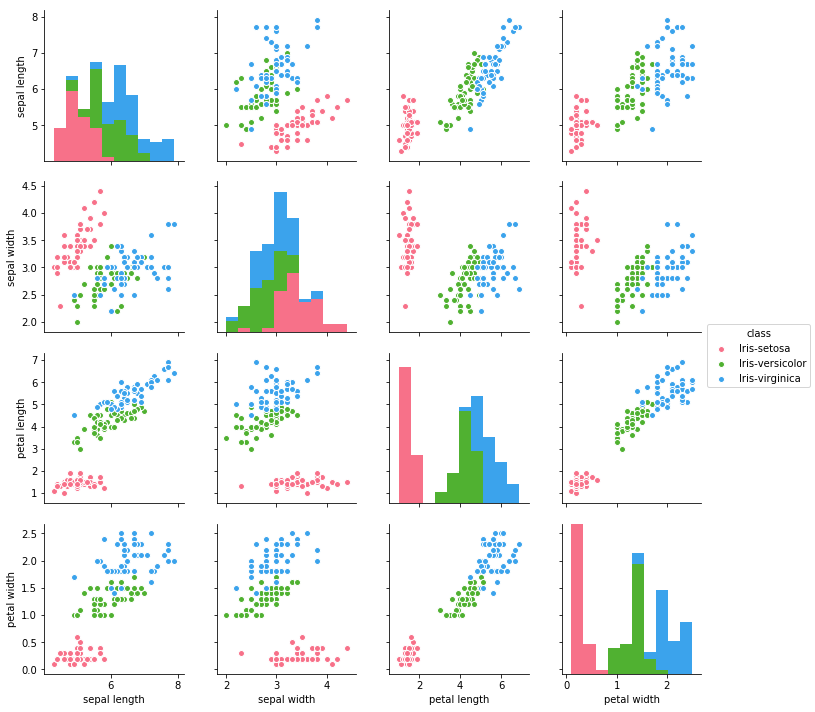

In [7]:
# 各特徴量で散布図作成
sns.pairplot(df, hue='class', palette='husl');
plt.show()

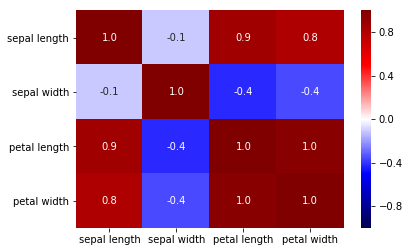

In [8]:
# 相関の確認
corr_mat = df.corr(method='pearson')
sns.heatmap(corr_mat,
            cmap='seismic',
            vmin=-1.0,
            vmax=1.0,
            center=0,
            annot=True, # True:格子の中に値を表示
            fmt='.1f',
            xticklabels=corr_mat.columns.values,
            yticklabels=corr_mat.columns.values
           )
plt.show()

## Iris-virginicaの検出

In [9]:
# データセットの作成
target = 'Iris-virginica'
df_nontarget = df[df['class']!=target]
X_train = df_nontarget.drop('class', axis=1)
y_train = (df_nontarget['class']!=target).astype(np.int32)
X_test = df.drop('class', axis=1)
y_test = (df['class']==target).astype(np.int32)

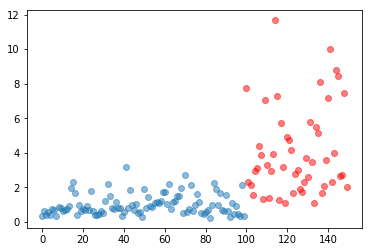

In [10]:
a = MT(X_train, X_test, y_test)

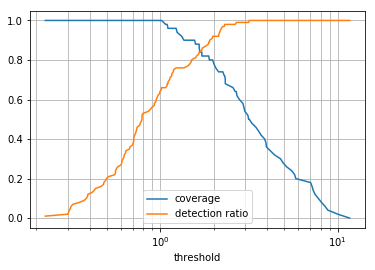

In [11]:
break_even(a, y_test)

## setosa の検出

In [12]:
# データセットの作成
target = 'Iris-setosa'
df_nontarget = df[df['class']!=target]
X_train = df_nontarget.drop('class', axis=1)
y_train = (df_nontarget['class']!=target).astype(np.int32)
X_test = df.drop('class', axis=1)
y_test = (df['class']==target).astype(np.int32)

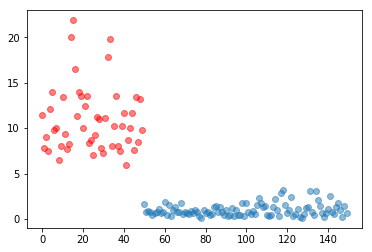

In [13]:
a = MT(X_train, X_test, y_test)

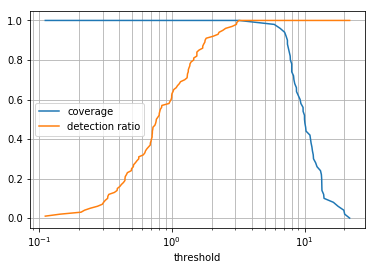

In [14]:
break_even(a, y_test)

## versicolor の検出

In [15]:
# データセットの作成
target = 'Iris-versicolor'
df_nontarget = df[df['class']!=target]
X_train = df_nontarget.drop('class', axis=1)
y_train = (df_nontarget['class']!=target).astype(np.int32)
X_test = df.drop('class', axis=1)
y_test = (df['class']==target).astype(np.int32)

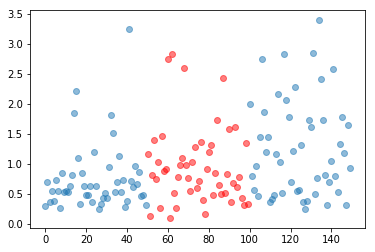

In [16]:
a = MT(X_train, X_test, y_test)

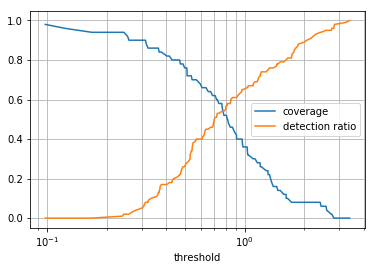

In [17]:
break_even(a, y_test)

#  breast_cancer

In [18]:
# ファイル読み込み
in_file = '../data/breast_cancer.csv'
df = pd.read_csv(in_file, header=0, index_col='Sample code number', sep=',')
df.head()

,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
Sample code number,,,,,,,,,,
1000025,5,1,1,1,2,1,3,1,1,2
1002945,5,4,4,5,7,10,3,2,1,2
1015425,3,1,1,1,2,2,3,1,1,2
1016277,6,8,8,1,3,4,3,7,1,2
1017023,4,1,1,3,2,1,3,1,1,2


In [19]:
df.describe()

,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bland Chromatin,Normal Nucleoli,Mitoses,Class
count,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000
mean,4.417740,3.134478,3.207439,2.806867,3.216023,3.437768,2.866953,1.589413,2.689557
std,2.815741,3.051459,2.971913,2.855379,2.214300,2.438364,3.053634,1.715078,0.951273
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000
25%,2.000000,1.000000,1.000000,1.000000,2.000000,2.000000,1.000000,1.000000,2.000000
50%,4.000000,1.000000,1.000000,1.000000,2.000000,3.000000,1.000000,1.000000,2.000000
75%,6.000000,5.000000,5.000000,4.000000,4.000000,5.000000,4.000000,1.000000,4.000000
max,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,4.000000


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 699 entries, 1000025 to 897471
Data columns (total 10 columns):
Clump Thickness                699 non-null int64
Uniformity of Cell Size        699 non-null int64
Uniformity of Cell Shape       699 non-null int64
Marginal Adhesion              699 non-null int64
Single Epithelial Cell Size    699 non-null int64
Bare Nuclei                    699 non-null object
Bland Chromatin                699 non-null int64
Normal Nucleoli                699 non-null int64
Mitoses                        699 non-null int64
Class                          699 non-null int64
dtypes: int64(9), object(1)
memory usage: 60.1+ KB


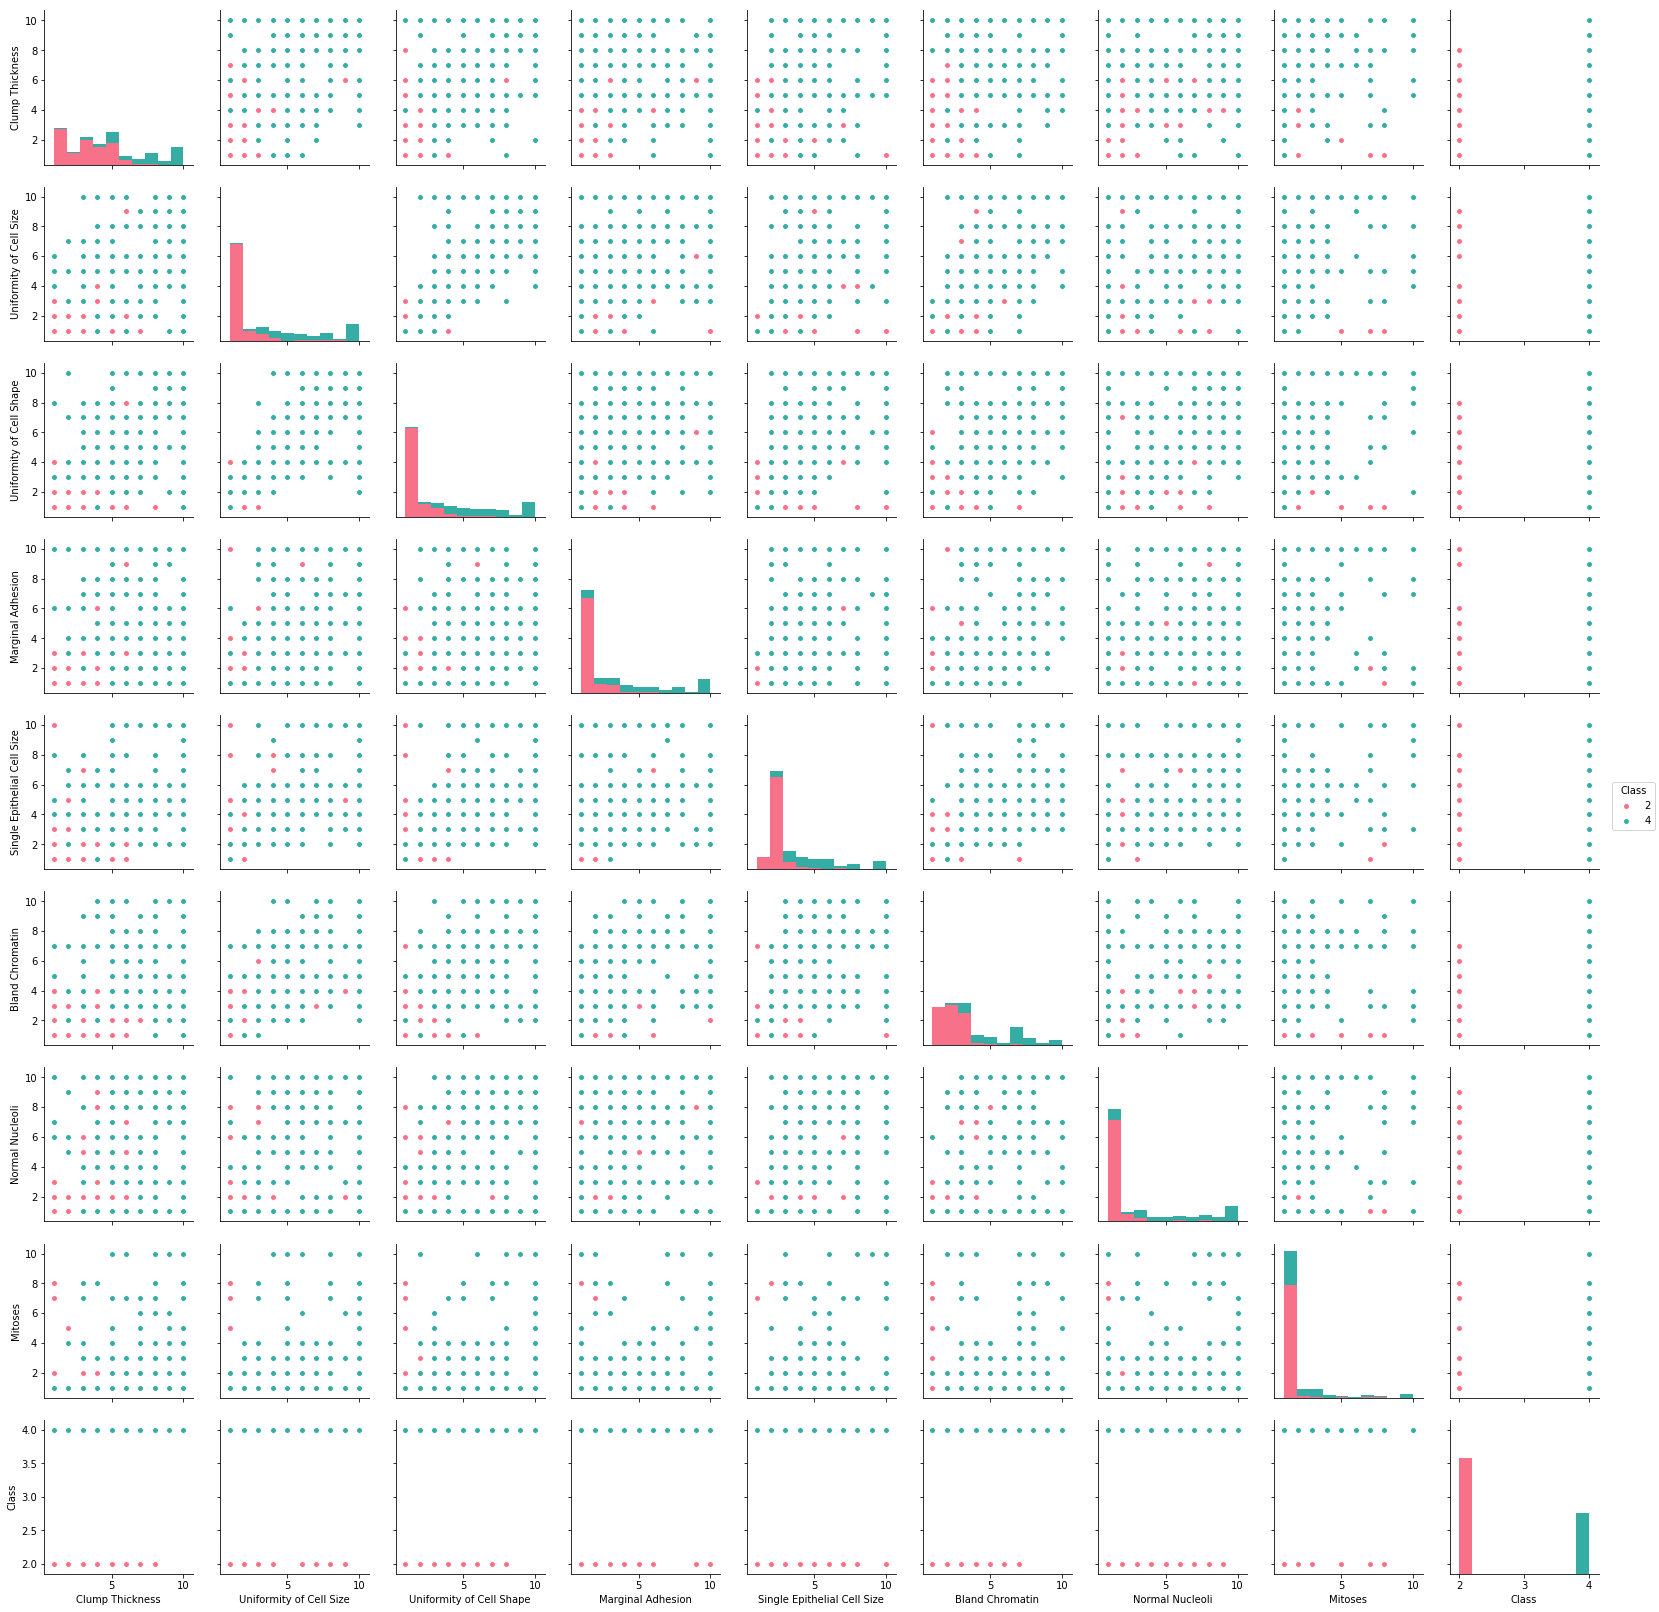

In [21]:
# 各特徴量で散布図作成
sns.pairplot(df, hue='Class', palette='husl');
plt.show()

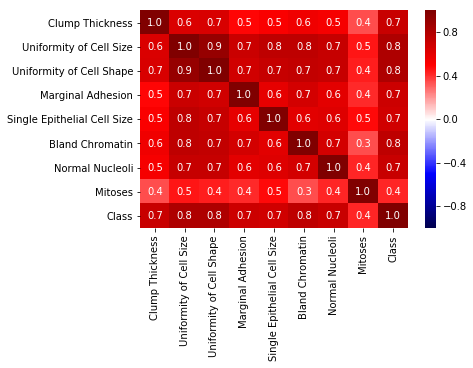

In [22]:
# 相関の確認
corr_mat = df.corr(method='pearson')
sns.heatmap(corr_mat,
            cmap='seismic',
            vmin=-1.0,
            vmax=1.0,
            center=0,
            annot=True, # True:格子の中に値を表示
            fmt='.1f',
            xticklabels=corr_mat.columns.values,
            yticklabels=corr_mat.columns.values
           )
plt.show()

In [23]:
# データセットの作成
target = 4
df = df.replace('?', np.nan)
df = df.dropna(how='any', axis=1)
df_nontarget = df[df['Class']!=target]
X_train = df_nontarget.drop('Class', axis=1)
y_train = (df_nontarget['Class']!=target).astype(np.int32)
X_test = df.drop('Class', axis=1)
y_test = (df['Class']==target).astype(np.int32)

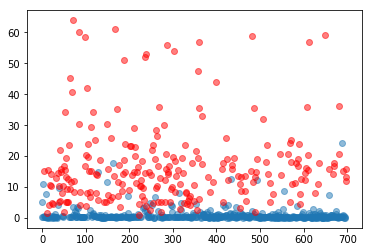

In [24]:
a = MT(X_train, X_test, y_test)

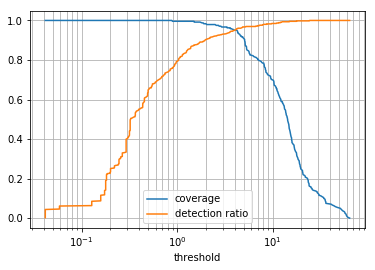

In [25]:
break_even(a, y_test)

# breast_cancer_coimbra

In [26]:
# ファイル読み込み
in_file = '../data/breast_cancer_coimbra.csv'
df = pd.read_csv(in_file, header=0, index_col=None, sep=',')
df.head()

,Age,BMI,Glucose,Insulin,HOMA,Leptin,Adiponectin,Resistin,MCP.1,Classification
0,48,23.500000,70,2.707,0.467409,8.8071,9.702400,7.99585,417.114,1
1,83,20.690495,92,3.115,0.706897,8.8438,5.429285,4.06405,468.786,1
2,82,23.124670,91,4.498,1.009651,17.9393,22.432040,9.27715,554.697,1
3,68,21.367521,77,3.226,0.612725,9.8827,7.169560,12.76600,928.220,1
4,86,21.111111,92,3.549,0.805386,6.6994,4.819240,10.57635,773.920,1


In [27]:
df.describe()

,Age,BMI,Glucose,Insulin,HOMA,Leptin,Adiponectin,Resistin,MCP.1,Classification
count,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000
mean,57.301724,27.582111,97.793103,10.012086,2.694988,26.615080,10.180874,14.725966,534.647000,1.551724
std,16.112766,5.020136,22.525162,10.067768,3.642043,19.183294,6.843341,12.390646,345.912663,0.499475
min,24.000000,18.370000,60.000000,2.432000,0.467409,4.311000,1.656020,3.210000,45.843000,1.000000
25%,45.000000,22.973205,85.750000,4.359250,0.917966,12.313675,5.474282,6.881763,269.978250,1.000000
50%,56.000000,27.662416,92.000000,5.924500,1.380939,20.271000,8.352692,10.827740,471.322500,2.000000
75%,71.000000,31.241442,102.000000,11.189250,2.857787,37.378300,11.815970,17.755207,700.085000,2.000000
max,89.000000,38.578759,201.000000,58.460000,25.050342,90.280000,38.040000,82.100000,1698.440000,2.000000


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116 entries, 0 to 115
Data columns (total 10 columns):
Age               116 non-null int64
BMI               116 non-null float64
Glucose           116 non-null int64
Insulin           116 non-null float64
HOMA              116 non-null float64
Leptin            116 non-null float64
Adiponectin       116 non-null float64
Resistin          116 non-null float64
MCP.1             116 non-null float64
Classification    116 non-null int64
dtypes: float64(7), int64(3)
memory usage: 9.1 KB


In [29]:
# クロス集計
df['Classification'].value_counts()

2    64
1    52
Name: Classification, dtype: int64

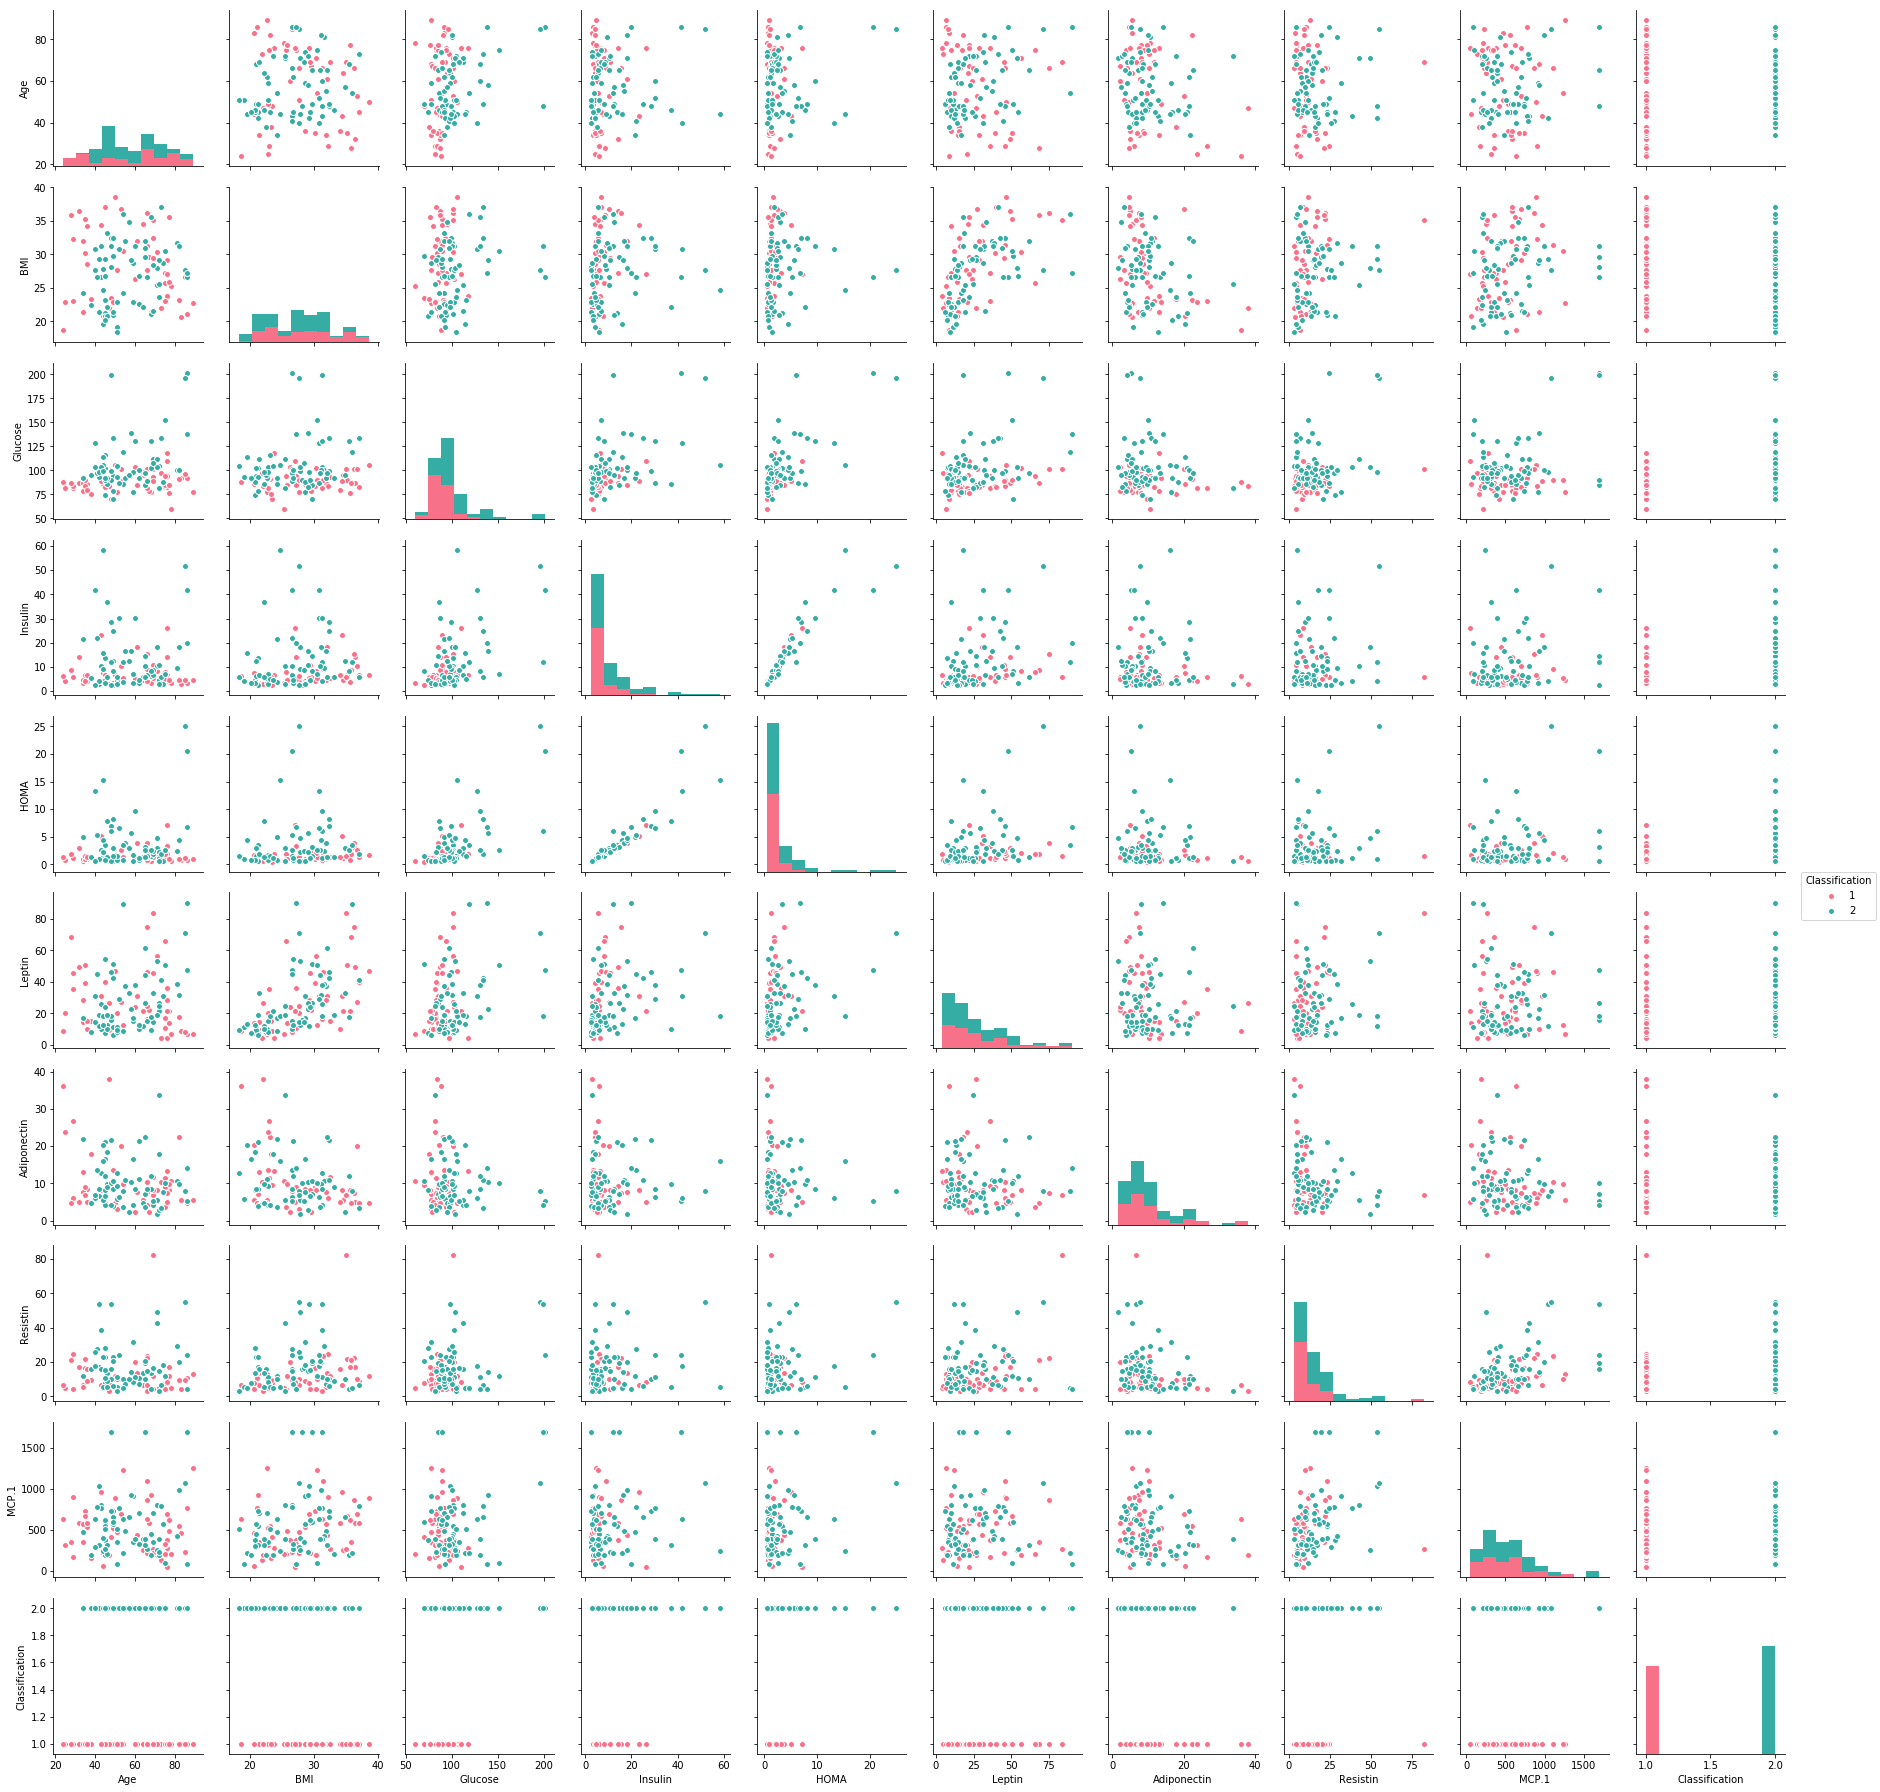

In [30]:
# 各特徴量で散布図作成
sns.pairplot(df, hue='Classification', palette='husl');
plt.show()

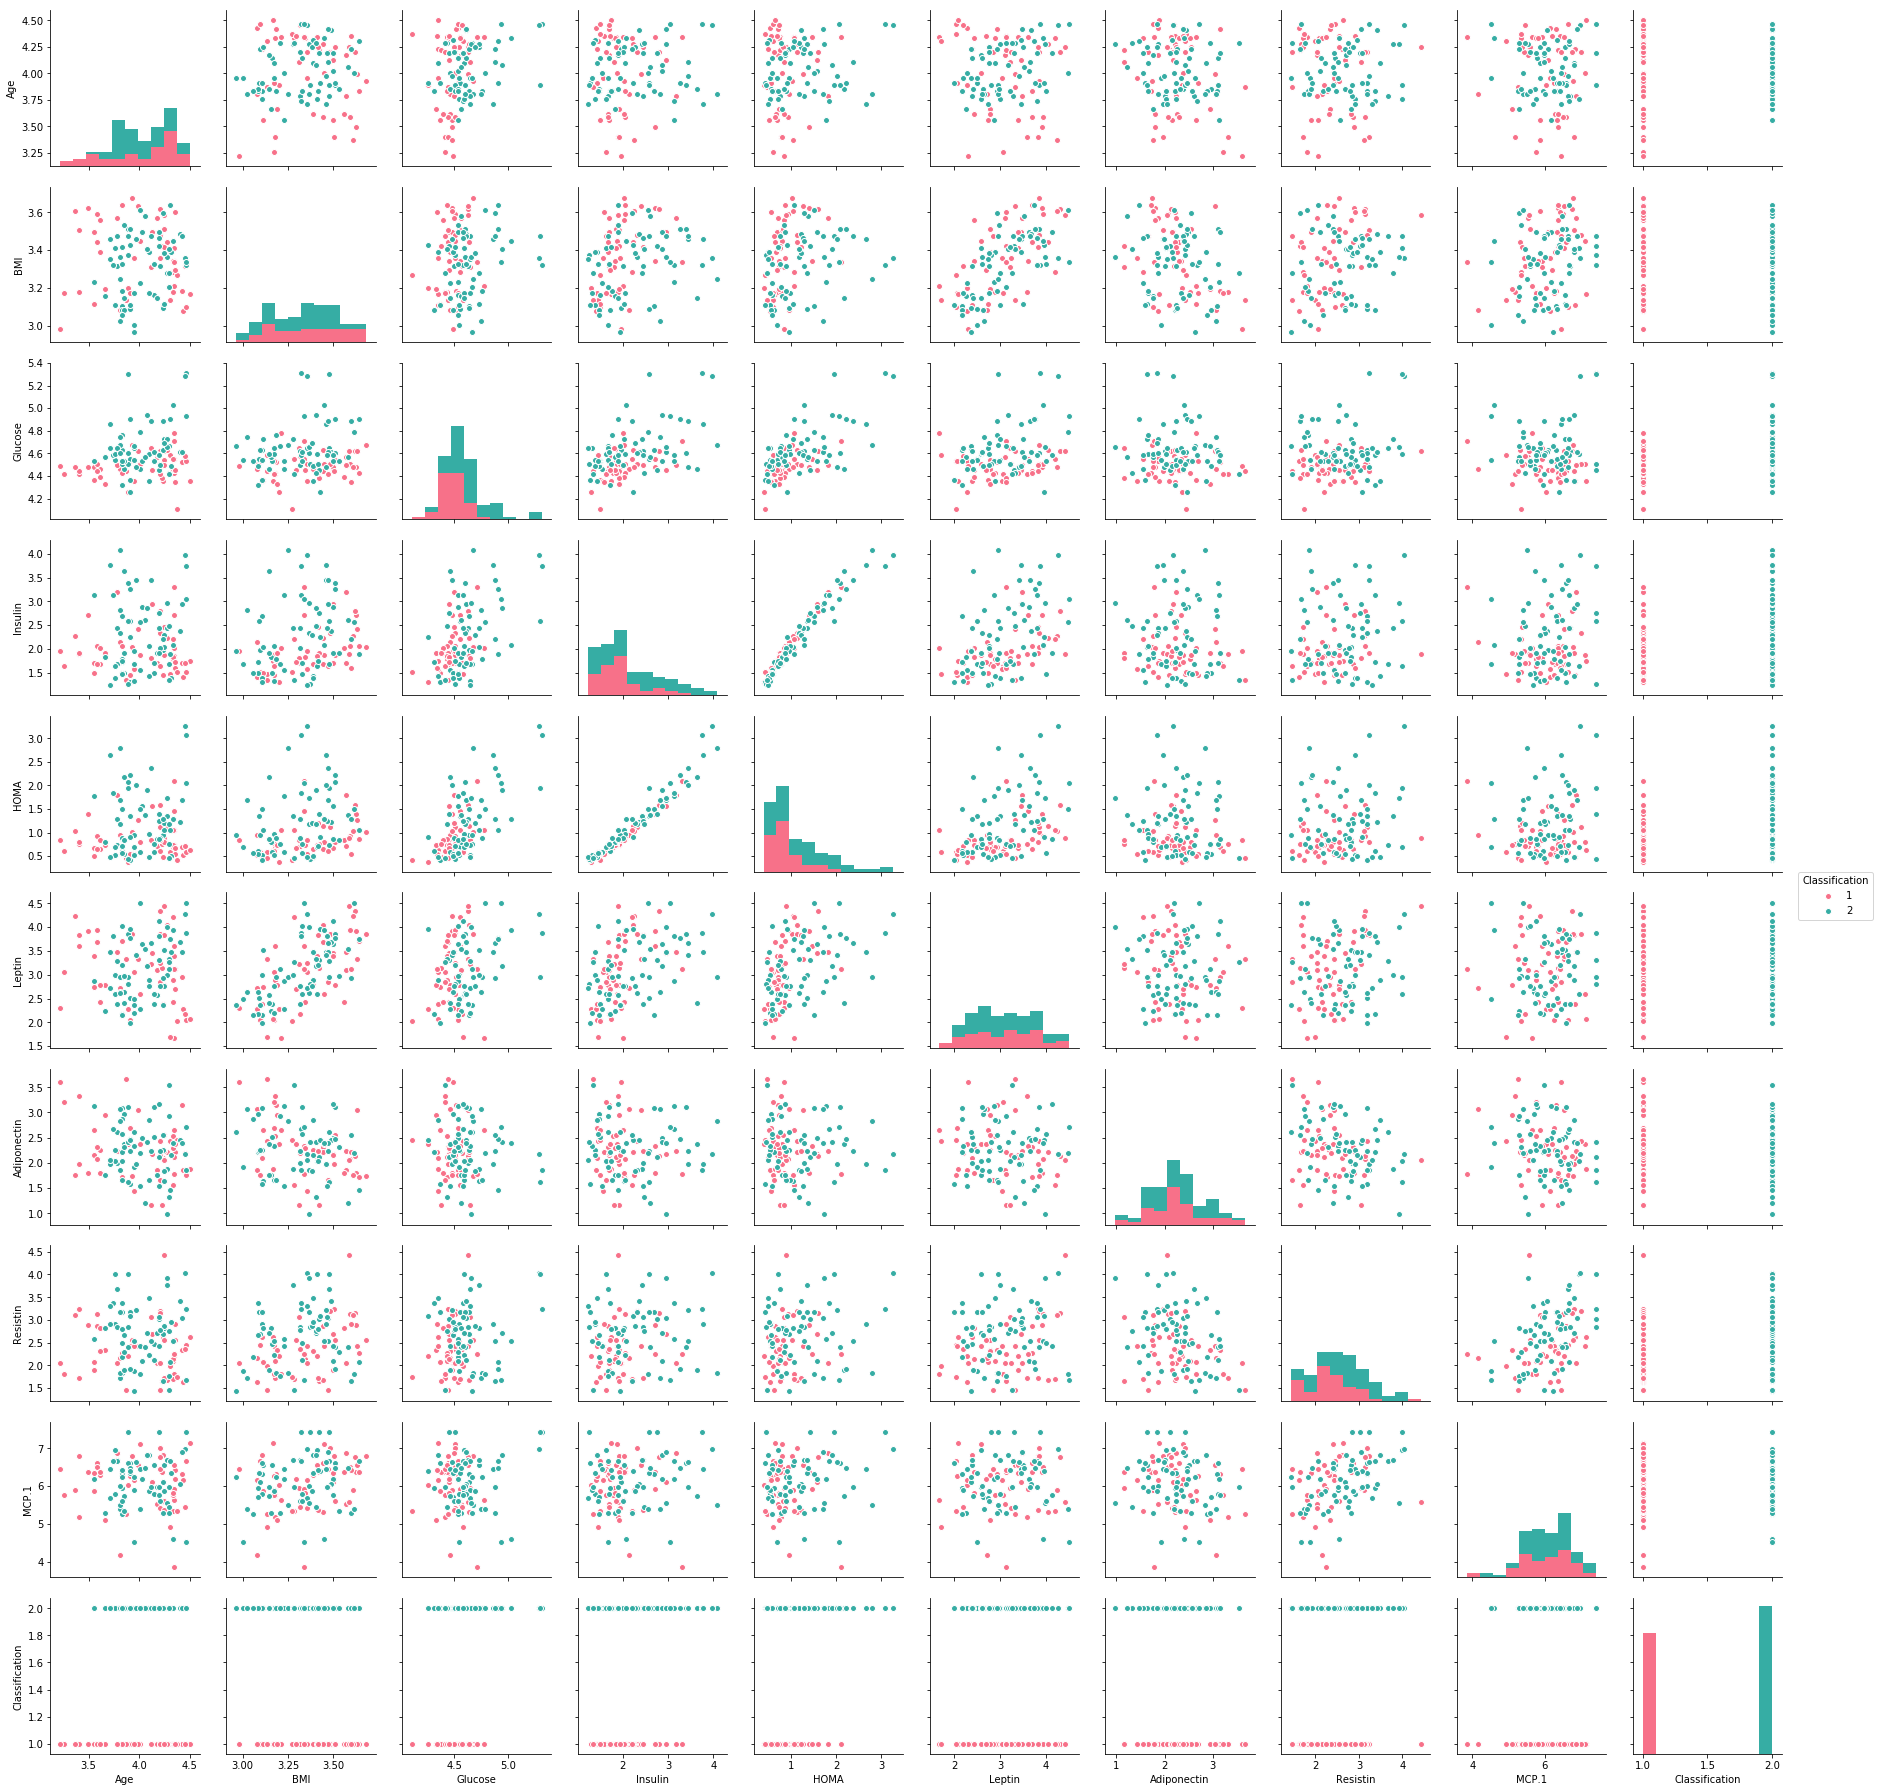

In [31]:
# 各特徴量で散布図作成
# Box-Cox
df_boxcox = np.log(df.drop('Classification', axis=1)+1)
df_boxcox = pd.concat([df_boxcox, df['Classification']], axis=1)
sns.pairplot(df_boxcox, hue='Classification', palette='husl');
plt.show()

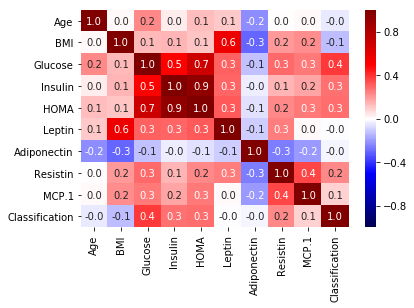

In [32]:
# 相関の確認
corr_mat = df.corr(method='pearson')
sns.heatmap(corr_mat,
            cmap='seismic',
            vmin=-1.0,
            vmax=1.0,
            center=0,
            annot=True, # True:格子の中に値を表示
            fmt='.1f',
            xticklabels=corr_mat.columns.values,
            yticklabels=corr_mat.columns.values
           )
plt.show()

In [33]:
# データセットの作成
target = 2
df_nontarget = df[df['Classification']!=target]
X_train = df_nontarget.drop('Classification', axis=1)
y_train = (df_nontarget['Classification']!=target).astype(np.int32)
X_test = df.drop('Classification', axis=1)
y_test = (df['Classification']==target).astype(np.int32)

# Box-Cox 変換
X_train = np.log(X_train + 1)
X_test = np.log(X_test + 1)

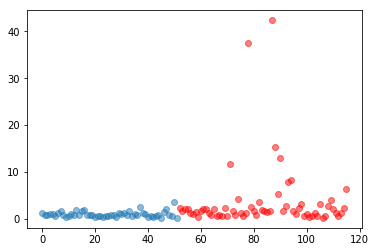

In [34]:
a = MT(X_train, X_test, y_test)

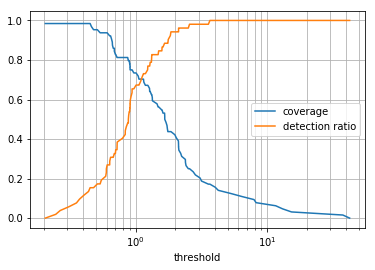

In [35]:
break_even(a, y_test)

# Optical Recognition of Handwritten Digits Data set

In [36]:
# ファイル読み込み
in_file = '../data/digits.csv'
df = pd.read_csv(in_file, header=None, index_col=None, sep=',')
df.head()

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,64
0,0,1,6,15,12,1,0,0,0,7,...,0,0,0,6,14,7,1,0,0,0
1,0,0,10,16,6,0,0,0,0,7,...,0,0,0,10,16,15,3,0,0,0
2,0,0,8,15,16,13,0,0,0,1,...,0,0,0,9,14,0,0,0,0,7
3,0,0,0,3,11,16,0,0,0,0,...,0,0,0,0,1,15,2,0,0,4
4,0,0,5,14,4,0,0,0,0,0,...,0,0,0,4,12,14,7,0,0,6


In [37]:
df.describe()

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,64
count,5620.0,5620.000000,5620.000000,5620.000000,5620.000000,5620.000000,5620.000000,5620.000000,5620.000000,5620.000000,...,5620.000000,5620.000000,5620.000000,5620.000000,5620.000000,5620.000000,5620.000000,5620.000000,5620.000000,5620.000000
mean,0.0,0.302135,5.393238,11.815480,11.578292,5.593772,1.379359,0.138256,0.003203,1.971174,...,0.166904,0.000356,0.281851,5.760498,11.989680,11.572420,6.720819,2.093594,0.254093,4.495196
std,0.0,0.879962,4.672719,4.255952,4.462546,5.631149,3.356633,1.046998,0.090423,3.098815,...,0.843455,0.018863,0.929969,5.021145,4.347542,4.975675,5.815564,4.047959,1.418558,2.868131
min,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,0.000000,1.000000,10.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,10.000000,9.000000,0.000000,0.000000,0.000000,2.000000
50%,0.0,0.000000,5.000000,13.000000,13.000000,4.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,5.000000,13.000000,13.000000,6.000000,0.000000,0.000000,4.000000
75%,0.0,0.000000,9.000000,15.000000,15.000000,10.000000,0.000000,0.000000,0.000000,3.000000,...,0.000000,0.000000,0.000000,10.000000,15.000000,16.000000,12.000000,2.000000,0.000000,7.000000
max,0.0,8.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,5.000000,16.000000,...,13.000000,1.000000,10.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,9.000000


In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5620 entries, 0 to 5619
Data columns (total 65 columns):
0     5620 non-null int64
1     5620 non-null int64
2     5620 non-null int64
3     5620 non-null int64
4     5620 non-null int64
5     5620 non-null int64
6     5620 non-null int64
7     5620 non-null int64
8     5620 non-null int64
9     5620 non-null int64
10    5620 non-null int64
11    5620 non-null int64
12    5620 non-null int64
13    5620 non-null int64
14    5620 non-null int64
15    5620 non-null int64
16    5620 non-null int64
17    5620 non-null int64
18    5620 non-null int64
19    5620 non-null int64
20    5620 non-null int64
21    5620 non-null int64
22    5620 non-null int64
23    5620 non-null int64
24    5620 non-null int64
25    5620 non-null int64
26    5620 non-null int64
27    5620 non-null int64
28    5620 non-null int64
29    5620 non-null int64
30    5620 non-null int64
31    5620 non-null int64
32    5620 non-null int64
33    5620 non-null int64
34    562

In [39]:
# クロス集計
df[64].value_counts()

3    572
1    571
4    568
7    566
9    562
6    558
5    558
2    557
8    554
0    554
Name: 64, dtype: int64

In [40]:
# 各特徴量で散布図作成
# => 特徴量多すぎて時間かかる
# sns.pairplot(df, hue=64, palette='husl');
# plt.show()

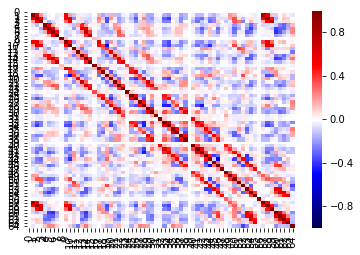

In [41]:
# 相関の確認
corr_mat = df.corr(method='pearson')
sns.heatmap(corr_mat,
            cmap='seismic',
            vmin=-1.0,
            vmax=1.0,
            center=0,
            annot=False, # True:格子の中に値を表示
            fmt='.1f',
            xticklabels=corr_mat.columns.values,
            yticklabels=corr_mat.columns.values
           )
plt.show()

In [42]:
# データセットの作成
target = 1
target_col = 64

# 標準偏差が0の列を除く
std_cols = df.std()
expl_cols = np.array([l for l in df.columns if std_cols[l]!=0])
df_ext = df[expl_cols]

df_nontarget = df_ext[df_ext[target_col]!=target]
X_train = df_nontarget.drop(target_col, axis=1)
y_train = (df_nontarget[target_col]!=target).astype(np.int32)
X_test = df_ext.drop(target_col, axis=1)
y_test = (df_ext[target_col]==target).astype(np.int32)

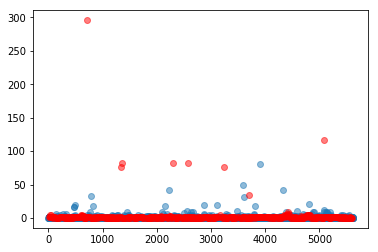

In [43]:
a = MT(X_train, X_test, y_test)

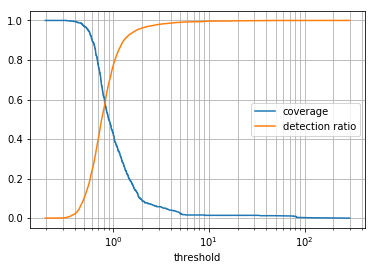

In [44]:
break_even(a, y_test)

# Urban Land Cover

In [45]:
# ファイル読み込み
in_file_train = '../data/urban_land_cover_training.csv'
in_file_test = '../data/urban_land_cover_testing.csv'
df_train = pd.read_csv(in_file_train, header=0, index_col=None, sep=',')
df_test = pd.read_csv(in_file_test, header=0, index_col=None, sep=',')
df = pd.concat([df_train, df_test], axis=0)
df.head()

,class,BrdIndx,Area,Round,Bright,Compact,ShpIndx,Mean_G,Mean_R,Mean_NIR,...,SD_NIR_140,LW_140,GLCM1_140,Rect_140,GLCM2_140,Dens_140,Assym_140,NDVI_140,BordLngth_140,GLCM3_140
0,car,1.27,91,0.97,231.38,1.39,1.47,207.92,241.74,244.48,...,26.18,2.00,0.50,0.85,6.29,1.67,0.70,-0.08,56,3806.36
1,concrete,2.36,241,1.56,216.15,2.46,2.51,187.85,229.39,231.20,...,22.29,2.25,0.79,0.55,8.42,1.38,0.81,-0.09,1746,1450.14
2,concrete,2.12,266,1.47,232.18,2.07,2.21,206.54,244.22,245.79,...,15.59,2.19,0.76,0.74,7.24,1.68,0.81,-0.07,566,1094.04
3,concrete,2.42,399,1.28,230.40,2.49,2.73,204.60,243.27,243.32,...,13.51,3.34,0.82,0.74,7.44,1.36,0.92,-0.09,1178,1125.38
4,concrete,2.15,944,1.73,193.18,2.28,4.10,165.98,205.55,208.00,...,15.65,50.08,0.85,0.49,8.15,0.23,1.00,-0.08,6232,1146.38


In [46]:
df['class'].value_counts()

building     122
concrete     116
grass        112
tree         106
shadow        61
asphalt       59
car           36
soil          34
pool          29
Name: class, dtype: int64

In [ ]:
df.shape

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 675 entries, 0 to 506
Columns: 148 entries, class to GLCM3_140
dtypes: float64(133), int64(14), object(1)
memory usage: 785.7+ KB


In [48]:
df.describe()

,BrdIndx,Area,Round,Bright,Compact,ShpIndx,Mean_G,Mean_R,Mean_NIR,SD_G,...,SD_NIR_140,LW_140,GLCM1_140,Rect_140,GLCM2_140,Dens_140,Assym_140,NDVI_140,BordLngth_140,GLCM3_140
count,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000,...,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000
mean,2.021437,563.342222,1.211541,165.602207,2.159852,2.265511,165.117274,162.635541,169.053748,10.577422,...,24.394252,2.973126,0.812430,0.614474,7.985689,1.490326,0.644311,0.024237,1295.318519,1145.129319
std,0.622732,693.523565,0.546297,62.852619,0.834899,0.714544,60.274195,72.876234,69.240038,5.024703,...,12.359619,5.250981,0.105816,0.195138,0.767758,0.457600,0.248885,0.139031,1062.153765,556.716342
min,1.000000,10.000000,0.000000,26.850000,1.000000,1.040000,22.910000,26.520000,31.110000,3.550000,...,2.650000,1.000000,0.200000,0.100000,5.690000,0.230000,0.030000,-0.360000,34.000000,211.270000
25%,1.570000,160.500000,0.825000,127.685000,1.620000,1.705000,132.900000,99.190000,112.530000,6.920000,...,14.290000,1.380000,0.760000,0.460000,7.365000,1.190000,0.460000,-0.080000,542.000000,758.280000
50%,1.940000,316.000000,1.180000,170.010000,1.990000,2.170000,189.410000,159.490000,167.830000,8.940000,...,22.190000,1.870000,0.830000,0.630000,7.940000,1.490000,0.680000,-0.030000,1050.000000,1054.670000
75%,2.380000,679.500000,1.500000,224.310000,2.480000,2.680000,207.690000,237.265000,237.470000,13.110000,...,33.290000,2.625000,0.890000,0.765000,8.645000,1.850000,0.850000,0.140000,1746.000000,1410.465000
max,4.530000,5767.000000,3.520000,245.870000,8.070000,5.410000,246.350000,253.610000,253.630000,36.400000,...,61.340000,64.700000,0.970000,1.000000,9.570000,2.410000,1.000000,0.370000,8896.000000,3806.360000


In [49]:
# データセットの作成
target = 'pool '
target_col = 'class'

# インデックスのリセット
df.reset_index(drop=True)

df_nontarget = df[df[target_col]!=target]  # 正常データサンプルを抽出
X_train = df_nontarget.drop(target_col, axis=1)  # 正常データのクラスラベルを削除して訓練データとする
y_train = (df_nontarget[target_col]==target).astype(np.int32)  # 正常データのラベル
X_test = df.drop(target_col, axis=1)  # 異常データを含む評価用データセット作成
y_test = (df[target_col]==target).astype(np.int32)  # 異常ラベル作成

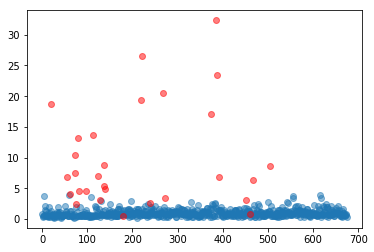

In [50]:
a = MT(X_train, X_test, y_test)

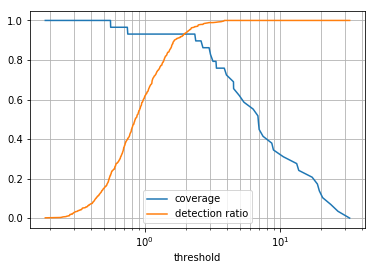

In [51]:
break_even(a, y_test)

# Online News Popularity

In [8]:
# ファイル読み込み
# pd.options.mode.chained_assignment = None
in_file = '../data/OnlineNewsPopularity.csv'
df = pd.read_csv(in_file, header=0, index_col=None, sep='\s*,\s*', engine='python')
df.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
0,http://mashable.com/2013/01/07/amazon-instant-...,731.0,12.0,219.0,0.663594,1.0,0.815385,4.0,2.0,1.0,...,0.100000,0.7,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500,593
1,http://mashable.com/2013/01/07/ap-samsung-spon...,731.0,9.0,255.0,0.604743,1.0,0.791946,3.0,1.0,1.0,...,0.033333,0.7,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000,711
2,http://mashable.com/2013/01/07/apple-40-billio...,731.0,9.0,211.0,0.575130,1.0,0.663866,3.0,1.0,1.0,...,0.100000,1.0,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000,1500
3,http://mashable.com/2013/01/07/astronaut-notre...,731.0,9.0,531.0,0.503788,1.0,0.665635,9.0,0.0,1.0,...,0.136364,0.8,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000,1200
4,http://mashable.com/2013/01/07/att-u-verse-apps/,731.0,13.0,1072.0,0.415646,1.0,0.540890,19.0,19.0,20.0,...,0.033333,1.0,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364,505


In [9]:
df.describe()

,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
count,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,...,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000
mean,354.530471,10.398749,546.514731,0.548216,0.996469,0.689175,10.883690,3.293638,4.544143,1.249874,...,0.095446,0.756728,-0.259524,-0.521944,-0.107500,0.282353,0.071425,0.341843,0.156064,3395.380184
std,214.163767,2.114037,471.107508,3.520708,5.231231,3.264816,11.332017,3.855141,8.309434,4.107855,...,0.071315,0.247786,0.127726,0.290290,0.095373,0.324247,0.265450,0.188791,0.226294,11626.950749
min,8.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,-1.000000,-1.000000,-1.000000,0.000000,-1.000000,0.000000,0.000000,1.000000
25%,164.000000,9.000000,246.000000,0.470870,1.000000,0.625739,4.000000,1.000000,1.000000,0.000000,...,0.050000,0.600000,-0.328383,-0.700000,-0.125000,0.000000,0.000000,0.166667,0.000000,946.000000
50%,339.000000,10.000000,409.000000,0.539226,1.000000,0.690476,8.000000,3.000000,1.000000,0.000000,...,0.100000,0.800000,-0.253333,-0.500000,-0.100000,0.150000,0.000000,0.500000,0.000000,1400.000000
75%,542.000000,12.000000,716.000000,0.608696,1.000000,0.754630,14.000000,4.000000,4.000000,1.000000,...,0.100000,1.000000,-0.186905,-0.300000,-0.050000,0.500000,0.150000,0.500000,0.250000,2800.000000
max,731.000000,23.000000,8474.000000,701.000000,1042.000000,650.000000,304.000000,116.000000,128.000000,91.000000,...,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.500000,1.000000,843300.000000


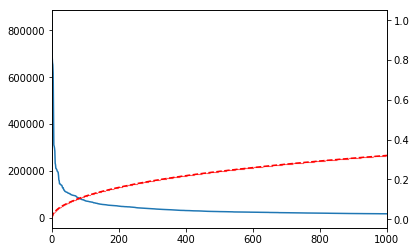

In [10]:
# 累積比率のグラフ
df_sort = df.sort_values('shares', ascending=False)
fig, ax = plt.subplots()
ax.set_xlim(0, 1000)
ax.plot(range(len(df_sort)), df_sort['shares'])
cumsum_ratio = df_sort['shares'].cumsum() / df_sort['shares'].sum()
ax2 = ax.twinx()
ax2.plot(range(len(df)), cumsum_ratio, ls='--', marker='o', color='r', markersize=.1)
plt.show()

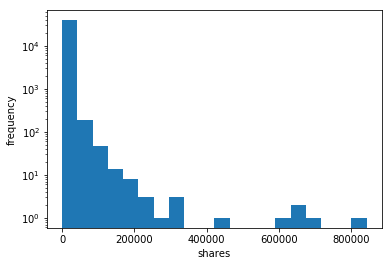

In [15]:
# ヒストグラム
plt.figure()
plt.hist(df_sort['shares'], bins=20)
plt.yscale('log')
plt.xlabel('shares')
plt.ylabel('frequency')
plt.show()

In [16]:
df[['shares', 'url']][:10]

,shares,url
0,593,http://mashable.com/2013/01/07/amazon-instant-...
1,711,http://mashable.com/2013/01/07/ap-samsung-spon...
2,1500,http://mashable.com/2013/01/07/apple-40-billio...
3,1200,http://mashable.com/2013/01/07/astronaut-notre...
4,505,http://mashable.com/2013/01/07/att-u-verse-apps/
5,855,http://mashable.com/2013/01/07/beewi-smart-toys/
6,556,http://mashable.com/2013/01/07/bodymedia-armba...
7,891,http://mashable.com/2013/01/07/canon-poweshot-n/
8,3600,http://mashable.com/2013/01/07/car-of-the-futu...
9,710,http://mashable.com/2013/01/07/chuck-hagel-web...


In [17]:
df.shape

(39644, 61)

In [25]:
df['url'][10]

'http://mashable.com/2013/01/07/cosmic-events-doomsday/'

In [28]:
# 上位1000件目のsharesを確認
df_sort['shares'][:1000]

9365     843300
5370     690400
23237    663600
16268    652900
3145     617900
16009    441000
18788    310800
4506     306100
16113    298400
35256    284700
14757    233400
3043     227300
37590    211600
9853     210300
18488    208300
17020    205600
37873    200100
18037    197600
9575     196700
18055    193400
17267    180600
36995    161600
16989    158900
23585    145500
25008    144900
3139     144400
12072    143100
23514    141400
16642    139600
18850    139500
          ...  
20199     17900
8231      17900
31139     17900
15998     17900
14860     17900
36937     17900
31116     17800
16852     17800
11064     17800
12721     17800
10816     17800
36163     17800
23144     17800
2645      17800
3517      17800
27551     17700
17981     17700
27195     17700
15370     17700
10421     17700
4586      17700
10492     17600
32962     17600
15941     17600
23115     17600
732       17600
33222     17600
10174     17600
37645     17600
5699      17600
Name: shares, Length: 10

In [29]:
# データセットの作成
target = 17600  # 上位1000件
target_col = 'shares'

# インデックスのリセット
df.reset_index(drop=True)

df_nontarget = df[df[target_col]<target]  # 正常データサンプルを抽出
X_train = df_nontarget.drop([target_col, 'url'], axis=1)  # 正常データのクラスラベルを削除して訓練データとする
y_train = (df_nontarget[target_col]>=target).astype(np.int32)  # 正常データのラベル
X_test = df.drop([target_col, 'url'], axis=1)  # 異常データを含む評価用データセット作成
y_test = (df[target_col]>=target).astype(np.int32)  # 異常ラベル作成

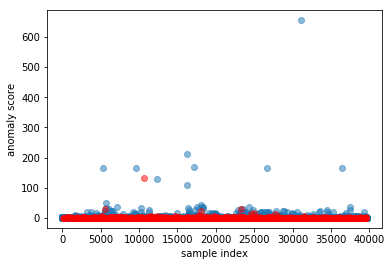

In [30]:
a = MT(X_train, X_test, y_test)

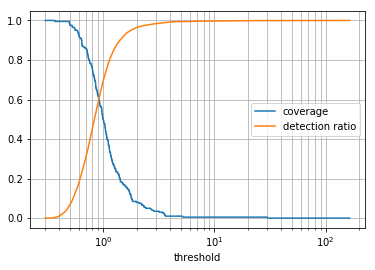

In [31]:
break_even(a[:10000], y_test[:10000])